In [1]:
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter

from os import listdir

/home/aimee/App/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers
import keras

import tensorflow as tf
from tensorflow.python.client import device_lib


In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17812805128486718692
]
[]


### Load images

In [4]:
TRAIN_FILE = "../datasets/DIV2K_train_HR/"
TEST_FILE = "../datasets/DIV2K_train_LR_wild/"
VALID_HR = "../datasets/DIV2K_valid_HR/"
VALID_LR = "../datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [5]:
valid_files[:5]

['0897.png', '0887.png', '0806.png', '0834.png', '0896.png']

In [6]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [7]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,50): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    train_img.append(Image.open(TEST_FILE + n[:-4]+"x4w1.png"))
    
    valid_hr_img.append(Image.open(VALID_HR +  m))
    valid_lr_img.append(Image.open(VALID_LR + m[:-4]+"x4w.png"))
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)#[image.convert('YCbCr') for image in obj_img]
ycbcr_train = convertToYCbCr(train_img)#[image.convert('YCbCr') for image in train_img]
ycbr_valid_hr = convertToYCbCr(valid_hr_img)
ycbr_valid_lr = convertToYCbCr(valid_lr_img)
#ycbr_valid_hr = [image.convert('YCbCr') for image ]

In [8]:
ycbcr_obj[0].size

(2040, 1140)

In [9]:
#Display images
def print_luminance(img, ch=3) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [10]:
#Convert images to numpy array
imgs_label = [np.asarray(image) for image in ycbcr_obj]
imgs_train = [np.asarray(image) for image in ycbcr_train]
imgs_valid_hr = [np.asarray(image) for image in ycbr_valid_hr]
imgs_valid_lr = [np.asarray(image) for image in ycbr_valid_lr]


In [11]:
imgs_label[0].shape

(1140, 2040, 3)

(1368, 2040, 3)


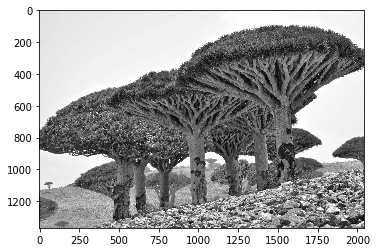

In [12]:
print(imgs_label[1].shape)
print_luminance(imgs_label[1])

(342, 510, 3)


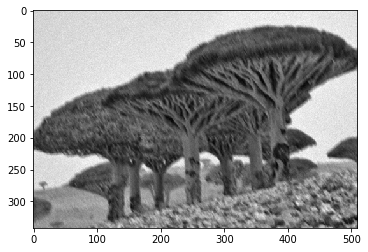

In [13]:
print(imgs_train[1].shape)
print_luminance(imgs_train[1])

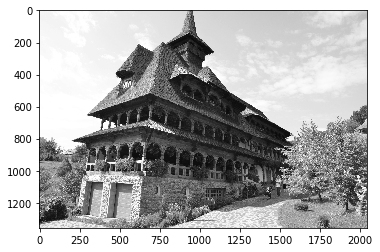

In [14]:
print_luminance(imgs_valid_hr[3])

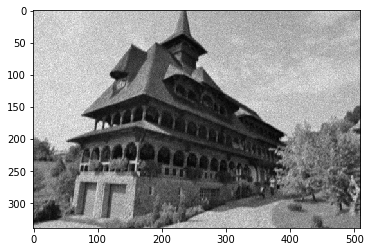

In [15]:
print_luminance(imgs_valid_lr[3])

### Generate train and test set

In [16]:
import pywt

In [17]:
#Division by 4
window_size= 200 
scale = 4

In [18]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [19]:
def getSubImage(img, height, width, scale = scale) :
    window = window_size // scale
    return img[ height // 2 - window : height//2 + window,
                width // 2 - window: width//2 + window : ]

In [20]:
count = 0
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,50) :
    label = imgs_label[i]
    sample = imgs_train[i]
    
    valid_hr = imgs_valid_hr[i]
    valid_lr = imgs_valid_lr[i]
    
    height_label, width_label = retSize(label)
    height_sample, width_sample = retSize(sample)
    height_hr, width_hr = retSize(valid_hr)
    height_vlr, width_vlr = retSize(valid_lr)
        
    #Calculate subimages
    sub_labels.append(getSubImage(label, height_label, width_label, scale= 1))
    
    sub_samples.append(getSubImage(sample, height_sample, width_sample))
                       
    sub_valid_hr.append(getSubImage(valid_hr, height_hr,width_hr, scale = 1))
                        
    sub_valid_lr.append(getSubImage(valid_lr, height_vlr, width_vlr))

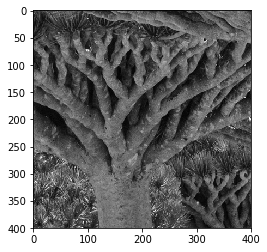

In [21]:
print_luminance(sub_labels[1])

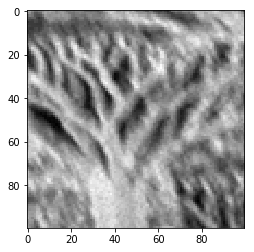

In [22]:
print_luminance(sub_samples[1])

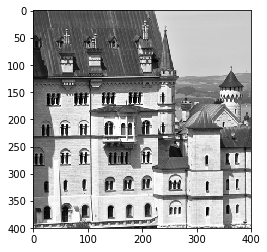

In [23]:
print_luminance(sub_valid_hr[1])

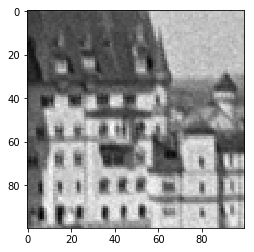

In [24]:
print_luminance(sub_valid_lr[1])

#### Generate the wavelets subbands

In [25]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [26]:
y_sample = sub_labels[-1]
x_sample = sub_samples[-1]
print(y_sample.shape)
print(x_sample.shape)

(400, 400, 3)
(100, 100, 3)


In [27]:
def plot_waveletTrans(wt, ch=1) :
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.title("Average")
    print_luminance(wt[0], ch )
    plt.subplot(222)
    print_luminance(wt[1][0], ch)
    plt.subplot(223)
    print_luminance(wt[1][1], ch)
    plt.subplot(224)
    print_luminance(wt[1][2], ch)

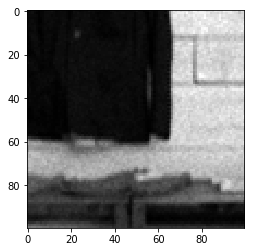

In [28]:
print_luminance(x_sample)

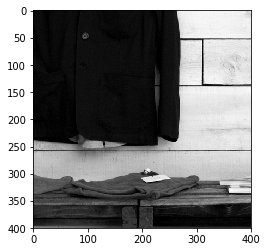

In [29]:
print_luminance(y_sample)

(55, 55)


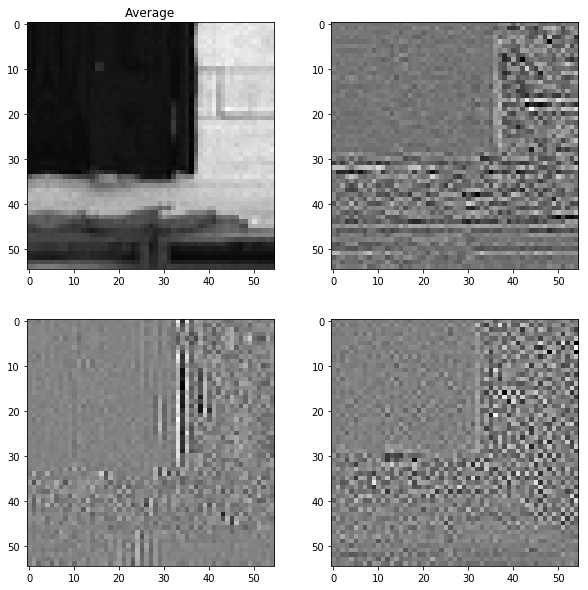

In [30]:
x_dwt = pywt.dwt2(x_sample[:,:, 0], 'db6')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

(205, 205)


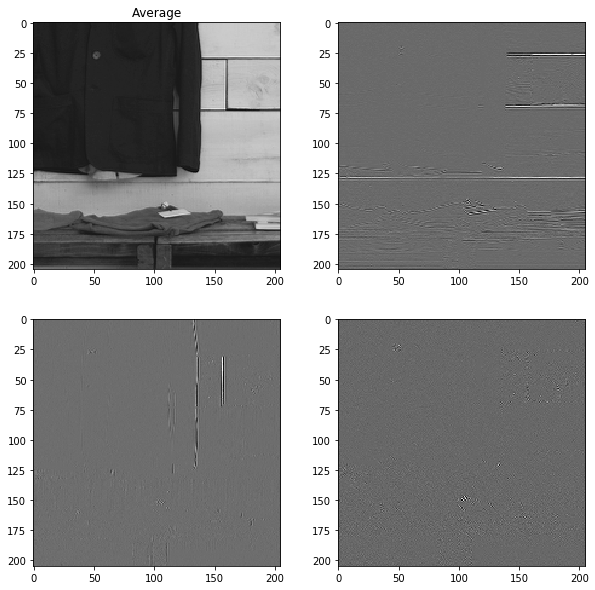

In [31]:
y_dwt = pywt.dwt2(y_sample[:,:, 0], 'db6')
print(y_dwt[0].shape)
plot_waveletTrans(y_dwt)

In [32]:
y_ll = []
y_lh = []
y_hl = []
y_hh = []

x_ll = []
x_lh = []
x_hl = []
x_hh = []

dwt_shape = []
dwt_hr_shape = []

valid_y_ll = []
valid_y_lh = []
valid_y_hl = []
valid_y_hh = []

valid_x_ll = []
valid_x_lh = []
valid_x_hl = []
valid_x_hh = []


for i in range(0,50) :
    y = sub_labels[i]
    x = sub_samples[i]
    vy = sub_valid_hr[i]
    vx = sub_valid_lr[i]
    
    dwt_y = pywt.dwt2(y[:, :, 0], 'db6')
    dwt_x = pywt.dwt2(x[:, :, 0], 'db6')
    dwt_hr = pywt.dwt2(vy[:, :, 0], 'db6')
    dwt_lr = pywt.dwt2(vx[:, :, 0], 'db6')
    
    y_ll, y_lh, y_hl, y_hh = appendSubbands(y_ll, y_lh, y_hl, y_hh, dwt_y)
    x_ll, x_lh, x_hl, x_hh = appendSubbands(x_ll, x_lh, x_hl, x_hh, dwt_x)

    valid_y_ll, valid_y_lh, valid_y_hl, valid_y_hh = appendSubbands(valid_y_ll, 
                                                                    valid_y_lh, 
                                                                    valid_y_hl, 
                                                                    valid_y_hh, dwt_hr)

    valid_x_ll, valid_x_lh, valid_x_hl, valid_x_hh = appendSubbands(valid_x_ll, 
                                                                    valid_x_lh, 
                                                                    valid_x_hl, 
                                                                    valid_x_hh, dwt_lr)
dwt_shape = dwt_x[0].shape
dwt_hr_shape = dwt_y[0].shape

#### Creating and Training the networks

In [33]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(int(matrix.shape[0] / (dwt_shape[0] * dwt_shape[1])), dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, int(matrix.shape[0] / (dwt_shape[0] * dwt_shape[1])), dwt_shape[0], dwt_shape[1])

In [34]:
img_rows = dwt_shape[0]
img_cols = dwt_shape[1]

channel = K.image_data_format()

x_train = reshape(x_ll, dwt_shape, channel)
y_train = reshape(y_ll, dwt_hr_shape, channel)
x_test = reshape(valid_x_ll, dwt_shape, channel)
y_test = reshape(valid_y_ll, dwt_hr_shape, channel)
input_shape_ = (img_rows, img_cols, 1)

In [35]:
y_train.shape

(50, 205, 205, 1)

In [36]:
def createModelCNNWith(kernel_size_, strides_, pool_size_, pool_strides_):
    model = Sequential()
    
    model.add(Conv2D(128, kernel_size=kernel_size_,strides=strides_,
                     activation='selu',
                     input_shape=input_shape_,
                     kernel_regularizer=regularizers.l2(0.0001)))
    
    model.add(Conv2D(256, (3, 3), activation='selu'))
    model.add(MaxPooling2D(pool_size=pool_size_, strides=pool_strides_))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    
    model.compile(optimizer=Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    
    return model

In [37]:
model2 = createModelCNNWith((3,3), (1,1), (2,2),(2,2))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 53, 53, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               81920512  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
__________

In [38]:
history_CNN_2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128, verbose=1)

ValueError: Error when checking target: expected dense_2 to have 2 dimensions, but got array with shape (50, 205, 205, 1)

#### Original image and bicubic interpolated image

In [42]:
'''label = modcrop(imgs[0], scale)
h, w = retSize(label)
sample = bicubicInterpolation(label, 1/3, (h,w))

fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(label)
getSize(label)
plt.subplot(122)
print_luminance(sample)

plt.show()'''


'label = modcrop(imgs[0], scale)\nh, w = retSize(label)\nsample = bicubicInterpolation(label, 1/3, (h,w))\n\nfig = plt.figure(figsize=(10, 5))\nplt.subplot(121)\nprint_luminance(label)\ngetSize(label)\nplt.subplot(122)\nprint_luminance(sample)\n\nplt.show()'

In [44]:
'''## Verify all images have the same size

samples_size = [s for s in samples if s.shape != (32, 32, 3)]
assert len(samples_size) == 0
labels_size = [s for s in labels if s.shape != (20, 20, 3)]
assert len(labels_size) == 0
count'''

'## Verify all images have the same size\n\nsamples_size = [s for s in samples if s.shape != (32, 32, 3)]\nassert len(samples_size) == 0\nlabels_size = [s for s in labels if s.shape != (20, 20, 3)]\nassert len(labels_size) == 0\ncount'

#### Example of our train and test set images

In [45]:
'''fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(samples[0])
getSize(label)
plt.subplot(122)
print_luminance(labels[0])
'''

'fig = plt.figure(figsize=(10, 5))\nplt.subplot(121)\nprint_luminance(samples[0])\ngetSize(label)\nplt.subplot(122)\nprint_luminance(labels[0])\n'